In [282]:
import mlflow
import polars as pl
import numpy as np
from pathlib import Path
from hydra import compose, initialize
from src.utils import construct_sparse_adj_mat
import json
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
)

In [328]:
with initialize(config_path="../configs/filepaths", version_base=None):
    fps = compose(config_name="base")

pred_dir = Path(fps.results) / "predictions"

In [ ]:
run_ids = {
    "rc_agg": "da9ed201898a451a8a822cf1a30ec30b",
    "rc_cxn": "af29e2f62cf34bf2824dc8c72e086da5",
    "bom": "d1a3cc3f1d36488e8222efda0d595914",
}

labels = {
    "rc_agg": "RC aggregated",
    "rc_cxn": "RC connected",
    "bom": "Bag of molecules",
    "cgr": "CGR",
    "clipzyme": "CLIPZyme",
    "rxnfp": "RXNFP",
    "drfp": "DRFP",
    "mfp": "Morgan fingerprint",
}

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.titlesize": 16,
})

colors = {
    "rc_agg": "purple",
    "rc_cxn": "forestgreen",
    "bom": "mediumblue",
    "cgr": "saddlebrown",
    "rxnfp": "silver",
    "mfp": "black",
    "drfp": "dimgray",
    "clipzyme": "maroon",
}

def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

metric_fcns = {
    "roc_auc": roc_auc_score,
    "fpr": fpr,
    "fnr": fnr,
}

x_labels = {
    'n_rcts_pdts': 'Number of reactants + products',
    'n_atoms_chunk': 'Number of atoms',
    'protein_seq_len_chunk': 'Protein sequence length (# residues)',
    'ec1': 'EC level 1',
    'ec2': 'EC level 2',
}

rcmcs_threshold = 0.7

In [352]:
preds = {
    k: pl.read_parquet(pred_dir / v / "target_output.parquet") for k, v in run_ids.items()
}

best_thresholds = {}
for name, id in run_ids.items():
    if not (pred_dir / id / 'best_thresholds.json').exists():
        print(f"No thresholds saved for {id2name[id]}, skipping...")
        continue
    
    with open(pred_dir / id / 'best_thresholds.json', 'r') as f:
        this = json.load(f)

    best_thresholds[name] = this['10']

In [353]:
toc = pl.read_csv(
    Path(fps.data) / "sprhea" / "v3_folded_pt_ns.csv",
    separator='\t'
)

adj, idx_sample, idx_feature = construct_sparse_adj_mat(Path(fps.data) / "sprhea" / "v3_folded_pt_ns.csv")
rid2idx = {int(v) : k for k, v in idx_feature.items()}
pid2idx = {v : k for k, v in idx_sample.items()}

with open(Path(fps.data) / "sprhea" / "v3_folded_pt_ns.json", 'r') as f:
    rxn_details = json.load(f)
    rxn_details = {rid2idx[int(k)]: v for k, v in rxn_details.items()}

with open(Path(fps.artifacts) / 'sprhea_folded_pt_ns_idx2ec.json', 'r') as f:
    rxn_idx2ec = json.load(f)
    rxn_idx2ec = {int(k): set(tuple(elt.split('.')) for elt in v) for k, v in rxn_idx2ec.items()}

Constructing v3_folded_pt_ns sparse adjacency matrix


In [354]:
ridx_2_n_atoms = {}
ridx_2_reactants_products = {}
for ridx, rxn in rxn_details.items():
    lhs, rhs = rxn['smarts'].split('>>')
    n_rcts = len(lhs.split('.'))
    n_pdts = len(rhs.split('.'))
    mol = Chem.MolFromSmarts(lhs)
    n_atoms = mol.GetNumAtoms()
    ridx_2_n_atoms[ridx] = n_atoms
    ridx_2_reactants_products[ridx] = n_rcts + n_pdts

In [355]:
pidx_2_seq_len = {
    pid2idx[row['Entry']]: len(row['Sequence'])
    for row in toc.iter_rows(named=True)
}

In [356]:
ec1 = {}
ec2 = {}
for idx, _ecs in rxn_idx2ec.items():
    for i in range(1,3):
        ec = list(set([".".join(elt[:i] )for elt in _ecs]))
        if i == 1:
            ec1[idx] = ec[0] if len(ec) > 0 else None
        else:
            ec2[idx] = ec[0] if len(ec) > 0 else None

In [357]:
preds['bom']

protein_idx,reaction_idx,pid,rid,y,logits,max_sim
i32,i32,str,str,i64,f32,f32
16113,5226,"""Q09KQ6""","""16449""",1,0.977414,0.5
21519,6100,"""P0DJQ7""","""9228""",1,0.633814,0.708333
5853,2476,"""P9WIN5""","""16898""",1,0.94093,0.976744
13019,4673,"""Q6F7B8""","""9043""",1,0.742991,0.893805
13020,4673,"""Q79FC3""","""9043""",1,0.084693,0.893805
…,…,…,…,…,…,…
4743,5038,"""Q5EA42""","""12910""",0,0.062223,0.0
7789,6102,"""P17585""","""13430""",0,0.000165,0.1
7824,2414,"""P38812""","""13106""",0,0.021014,0.746835


In [358]:
for k, pred in preds.items():
    pred = pred.with_columns(
        pl.col("protein_idx").replace_strict(pidx_2_seq_len).alias("protein_seq_len"),
        pl.col("reaction_idx").replace_strict(ridx_2_n_atoms).alias("n_atoms"),
        pl.col("reaction_idx").replace_strict(ridx_2_reactants_products).alias("n_rcts_pdts"),
        pl.col("reaction_idx").replace_strict(ec1, return_dtype=pl.String).alias("ec1"),
        pl.col("reaction_idx").replace_strict(ec2, return_dtype=pl.String,).alias("ec2"),
        pl.col("logits").map_elements(lambda x : x > best_thresholds[k], return_dtype=pl.Int32).alias('y_pred'),
    ).filter(
        pl.col("ec1").is_not_null(),
        pl.col("ec2").is_not_null(),
        pl.col("max_sim") < rcmcs_threshold,
        
    )
    preds[k] = pred

In [359]:
n_chunks = 5

for col in ['n_atoms', 'protein_seq_len']:
    for k, pred in preds.items():
        percentiles = np.percentile(pred[col].to_list(), np.linspace(0, 100, n_chunks))
        chunk_labels = [f"<{int(percentiles[0])}"] + [f"{int(percentiles[i])}-{int(percentiles[i+1])}" for i in range(len(percentiles)-1)] + [f">{int(percentiles[-1])}"]
        pred = pred.with_columns(
            pl.col(col).cut(breaks=percentiles, labels=chunk_labels, left_closed=True).alias(f"{col}_chunk")
        )
        gb = pred.group_by(f"{col}_chunk").agg(
            pl.col("y").mean().alias("pos_frac"),
            pl.len().alias("n"),
        ).sort(f"{col}_chunk")
        black_list = gb.filter(pl.col("n") < 50)[f"{col}_chunk"].to_list()
        print(f"Excluding {black_list} for having less than 50 samples.")
        pred = pred.filter(
            ~pl.col(f"{col}_chunk").is_in(black_list)
        )
        preds[k] = pred

Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding [] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.
Excluding ['>5537'] for having less than 50 samples.


In [360]:
def clustered_bar_plot(group_col, metric, metrics_fcns=metric_fcns, preds=preds, labels=labels, x_labels=x_labels, colors=colors):
    '''
    Creates clustered bar plot with an x-tick for each unique value of `group_col` and as many
    bars per col as there are models in preds (names of which are keys in preds dict).
    '''
    fig, ax = plt.subplots(figsize=(14, 4))
    groups = sorted(preds[next(iter(preds))][group_col].unique().to_list())

    if "chunk" in group_col:
        groups = [
            elt[1] for elt in sorted(
                [ (int(elt.split('-')[0].replace('<','').replace('>','')), elt) for elt in groups ]
            )
        ]

    n_models = len(preds)
    width = 0.8 / n_models

    for i, (name, pred) in enumerate(preds.items()):
        vals = []
        for g in groups:
            sub = pred.filter(pl.col(group_col) == g)
            y_true = sub["y"].to_list()
            y_hat = sub["logits"].to_list() if metric == "roc_auc" else sub["y_pred"].to_list()
            vals.append(metrics_fcns[metric](y_true, y_hat))
        xs = [x + (i - (n_models - 1) / 2) * width for x in range(len(groups))]
        ax.bar(xs, vals, width=width, label=labels.get(name, name), color=colors.get(name))

    ax.set_xticks(range(len(groups)))
    ax.set_xticklabels(groups, rotation=45)
    ax.set_xlabel(x_labels.get(group_col, group_col))
    ax.set_ylabel(metric.replace('_', '-').upper())
    if metric == "roc_auc":
        ax.set_ylim([0.4, 1.05])
    ax.legend(bbox_to_anchor=(1.01, 1.0))
    fig.tight_layout()
    return fig, ax

(<Figure size 1400x400 with 1 Axes>,
 <Axes: xlabel='Protein sequence length (# residues)', ylabel='FNR'>)

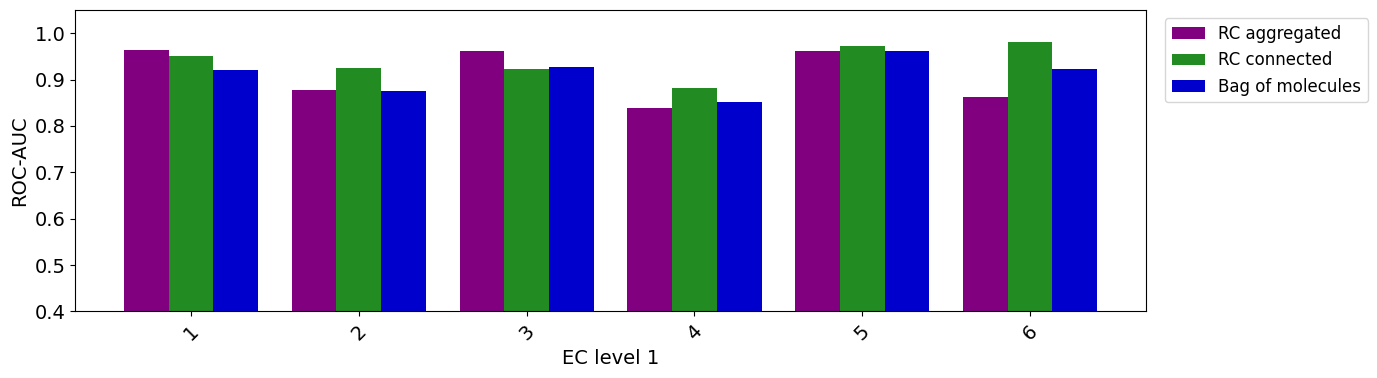

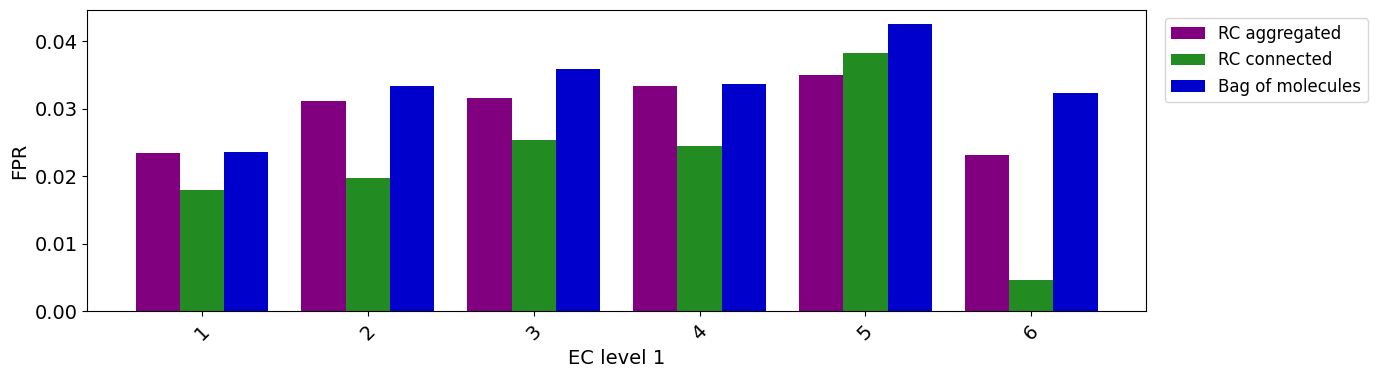

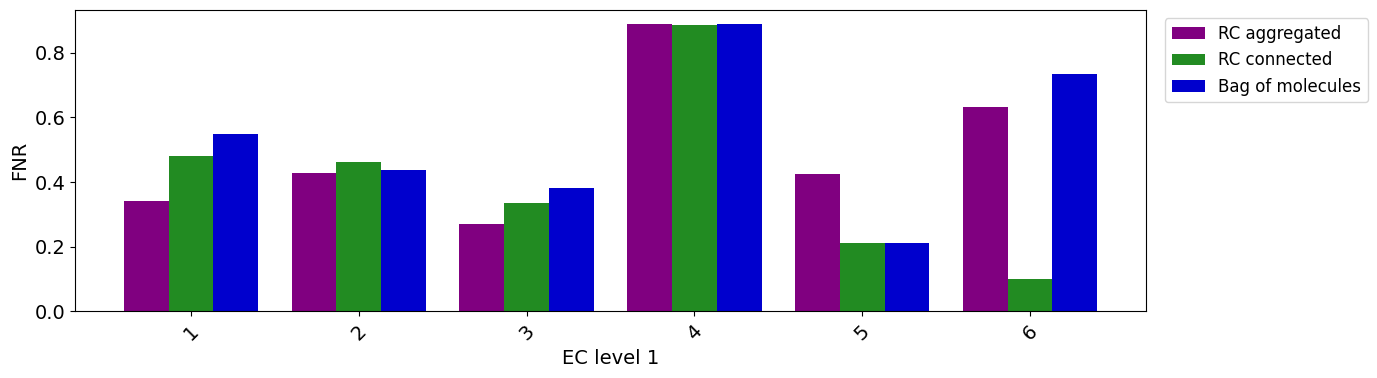

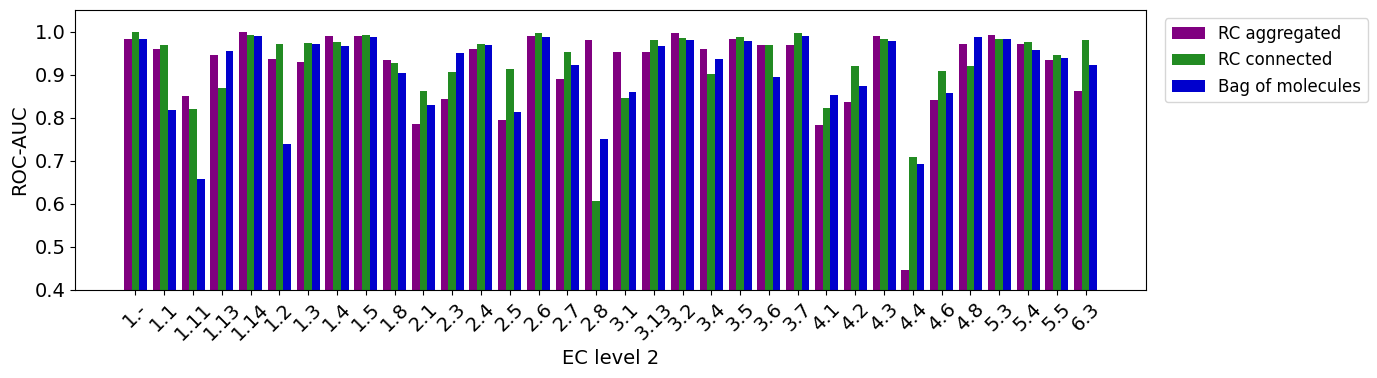

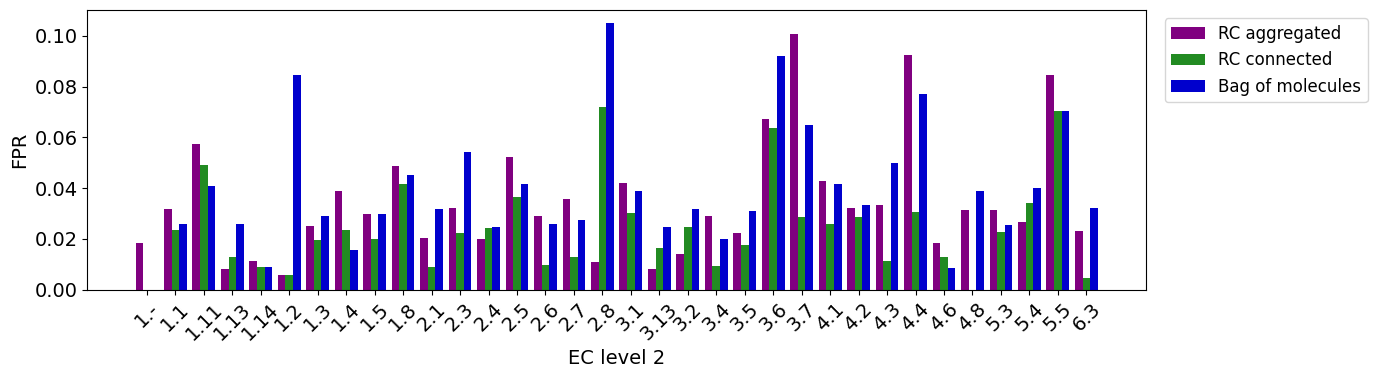

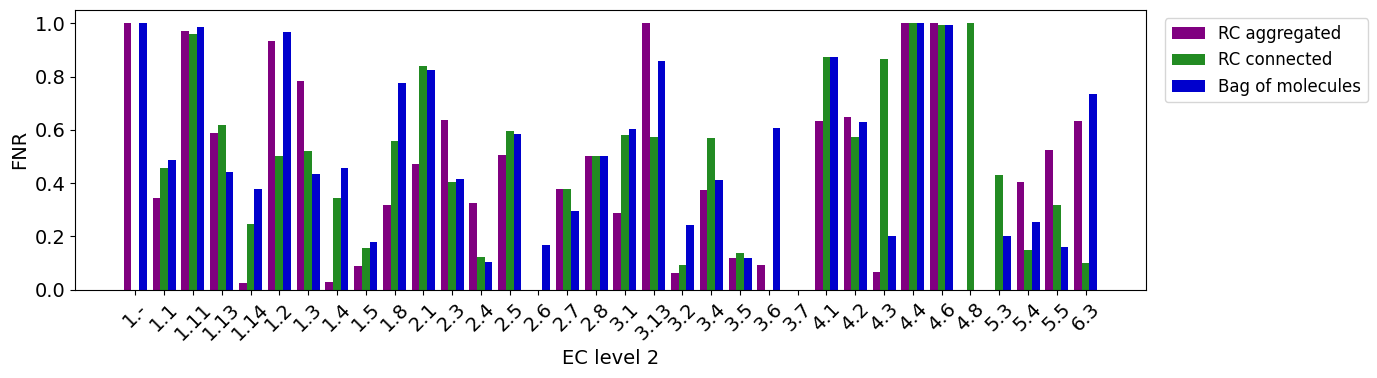

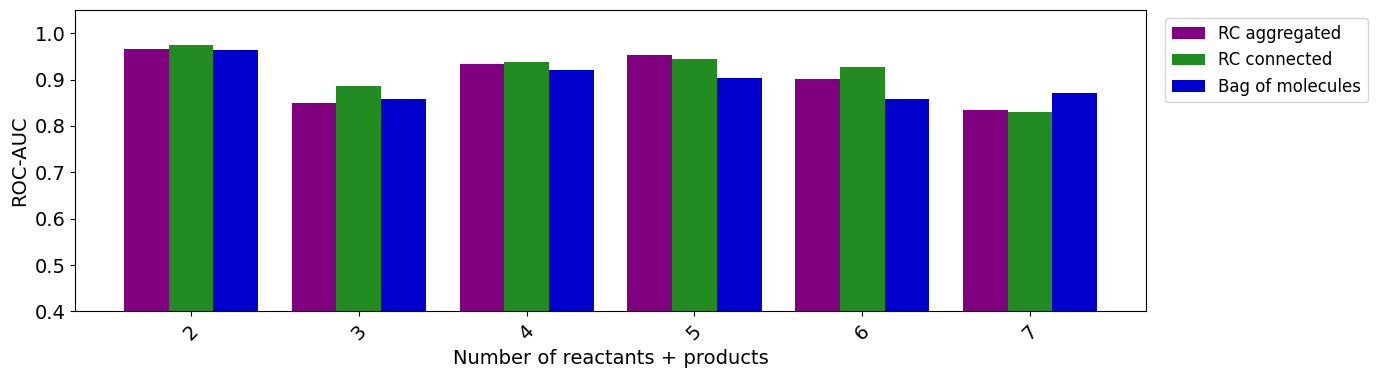

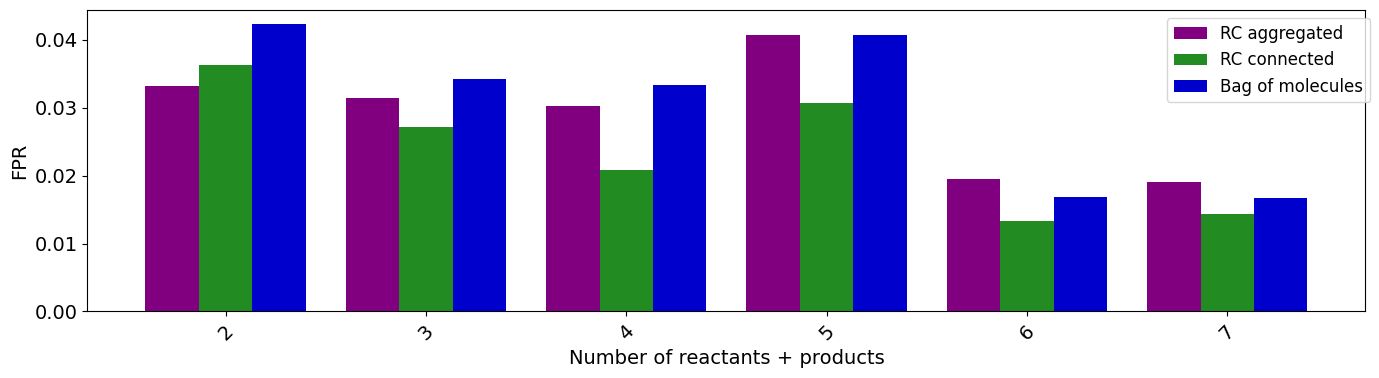

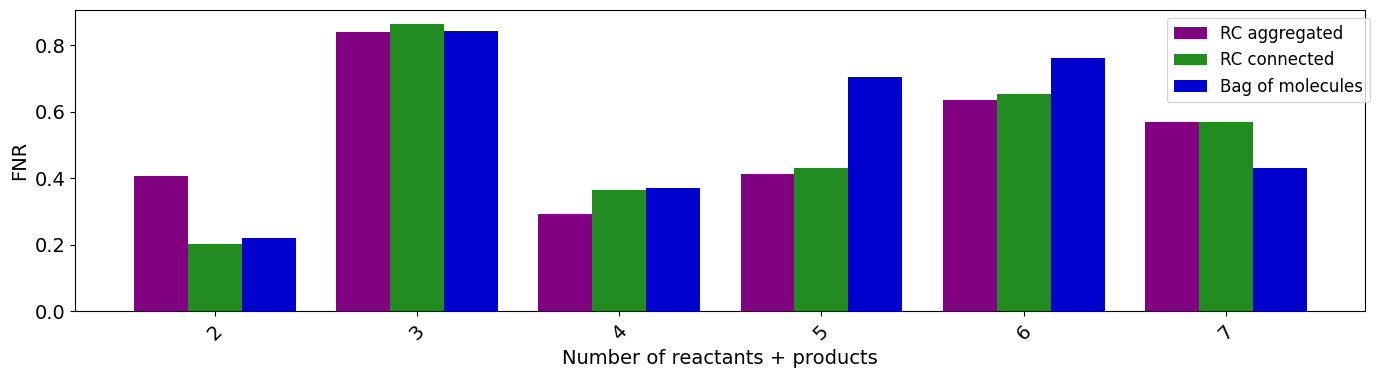

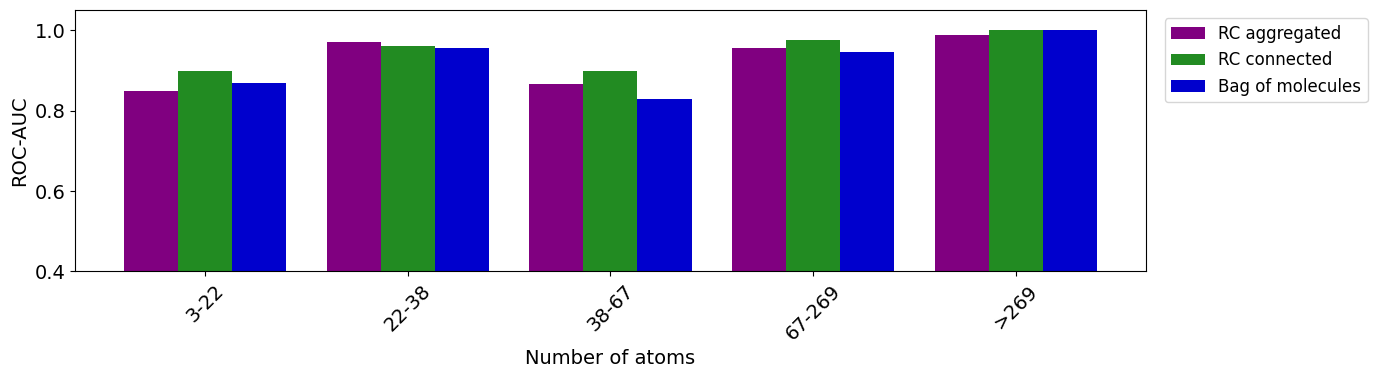

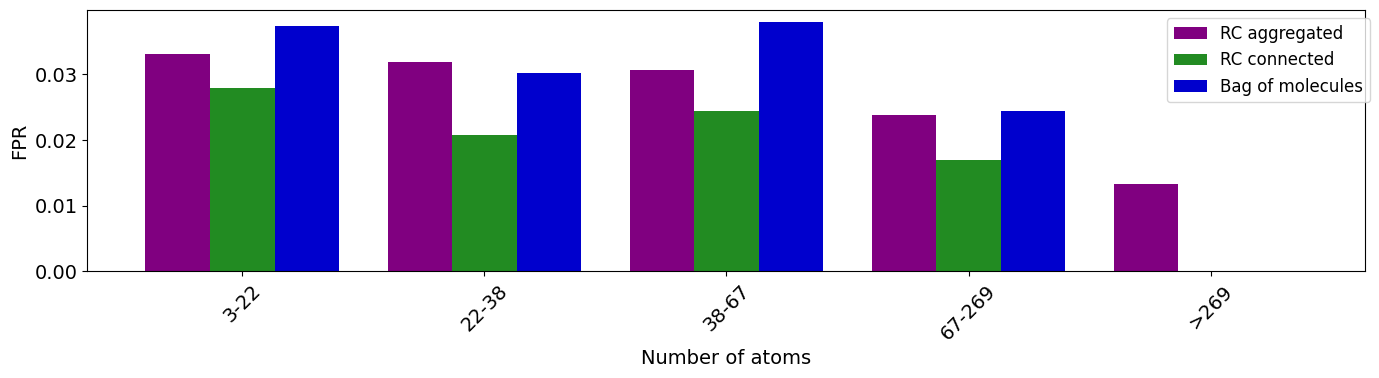

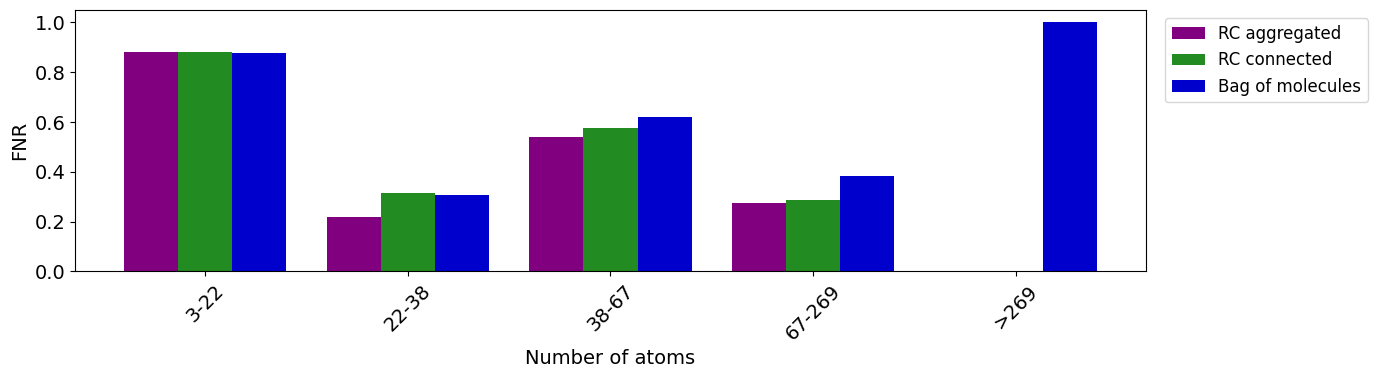

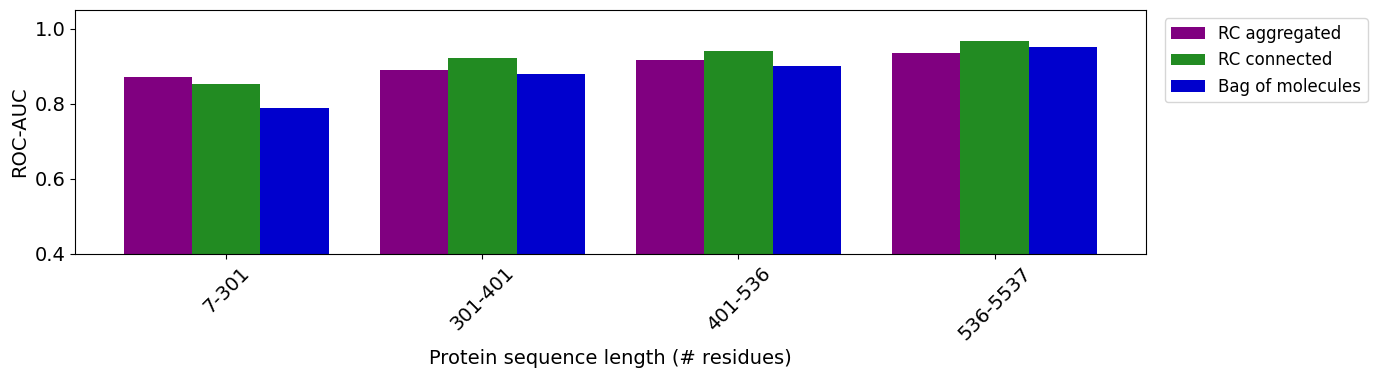

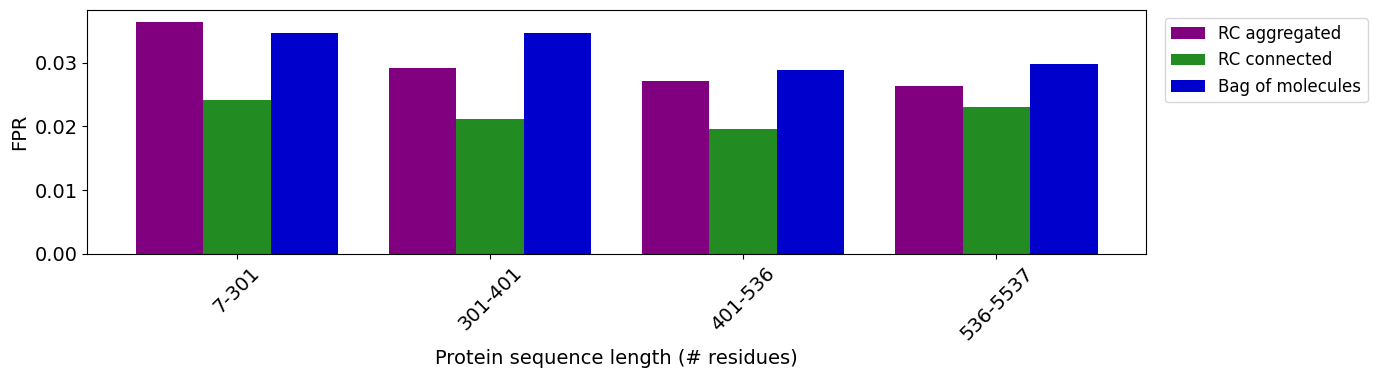

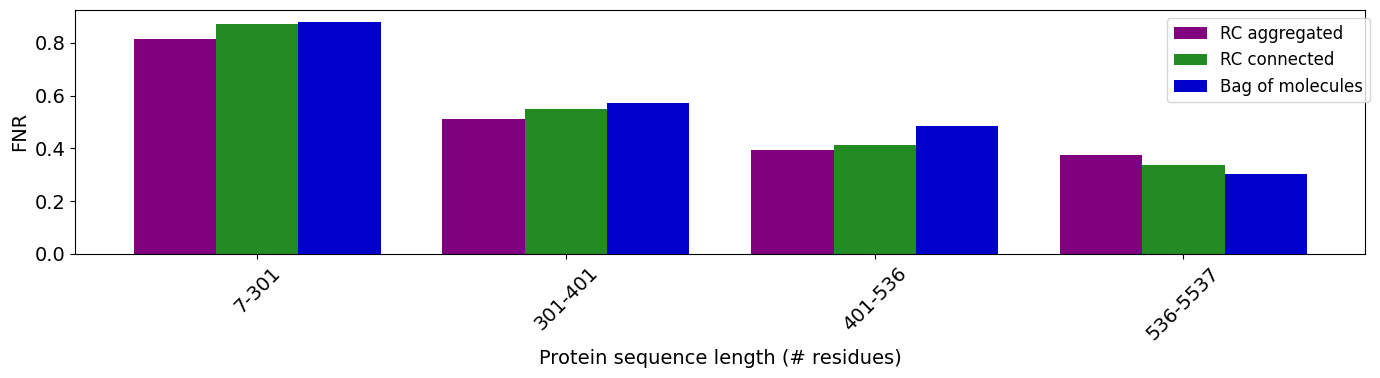

In [361]:
clustered_bar_plot('ec1', 'roc_auc')
clustered_bar_plot('ec1', 'fpr')
clustered_bar_plot('ec1', 'fnr')
clustered_bar_plot('ec2', 'roc_auc')
clustered_bar_plot('ec2', 'fpr')
clustered_bar_plot('ec2', 'fnr')
clustered_bar_plot('n_rcts_pdts', 'roc_auc')
clustered_bar_plot('n_rcts_pdts', 'fpr')
clustered_bar_plot('n_rcts_pdts', 'fnr')
clustered_bar_plot('n_atoms_chunk', 'roc_auc')
clustered_bar_plot('n_atoms_chunk', 'fpr')
clustered_bar_plot('n_atoms_chunk', 'fnr')
clustered_bar_plot('protein_seq_len_chunk', 'roc_auc')
clustered_bar_plot('protein_seq_len_chunk', 'fpr')
clustered_bar_plot('protein_seq_len_chunk', 'fnr')

In [362]:
preds['bom']

protein_idx,reaction_idx,pid,rid,y,logits,max_sim,protein_seq_len,n_atoms,n_rcts_pdts,ec1,ec2,y_pred,n_atoms_chunk,protein_seq_len_chunk
i32,i32,str,str,i64,f32,f32,i64,i64,i64,str,str,i32,cat,cat
16113,5226,"""Q09KQ6""","""16449""",1,0.977414,0.5,251,12,4,"""3""","""3.5""",1,"""3-22""","""7-301"""
3840,1058,"""P53816""","""8551""",1,0.97309,0.509804,162,27,4,"""3""","""3.1""",1,"""22-38""","""7-301"""
3842,1058,"""Q9NWW9""","""8551""",1,0.991791,0.509804,162,27,4,"""3""","""3.1""",1,"""22-38""","""7-301"""
3843,1058,"""P53817""","""8551""",1,0.988319,0.509804,160,27,4,"""3""","""3.1""",1,"""22-38""","""7-301"""
3844,1058,"""Q5R611""","""8551""",1,0.979813,0.509804,162,27,4,"""3""","""3.1""",1,"""22-38""","""7-301"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4198,4566,"""P14219""","""13015""",0,0.887666,0.0,379,54,4,"""1""","""1.1""",1,"""38-67""","""301-401"""
13821,2353,"""Q6CIB4""","""2650""",0,0.000779,0.264151,410,26,4,"""3""","""3.5""",0,"""22-38""","""401-536"""
4743,5038,"""Q5EA42""","""12910""",0,0.062223,0.0,425,30,3,"""4""","""4.2""",0,"""22-38""","""401-536"""


In [363]:
S_rcmcs = np.load(Path(fps.results) / 'similarity_matrices' / 'sprhea_v3_folded_pt_ns_rcmcs.npy')

- get false pos errors
- get true reactoin pairs of protein
- calc rcmcs of query reaction to each of these
- get max over this

In [380]:
max_sim_missed = {k: [] for k in preds.keys()}
for k, pred in preds.items():
    false_positives = pred.filter((pl.col("y") == 0) & (pl.col("y_pred") == 1))
    for row in false_positives.iter_rows(named=True):
        ridx = row['reaction_idx']
        pidx = row['protein_idx']
        i = pidx
        col_indices = adj.getrow(i).nonzero()[1]
        max_sim = S_rcmcs[ridx, col_indices].max()
        max_sim_missed[k].append(max_sim)

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Maximum similarity of missed positive samples', ylabel='Cumulative fraction'>)

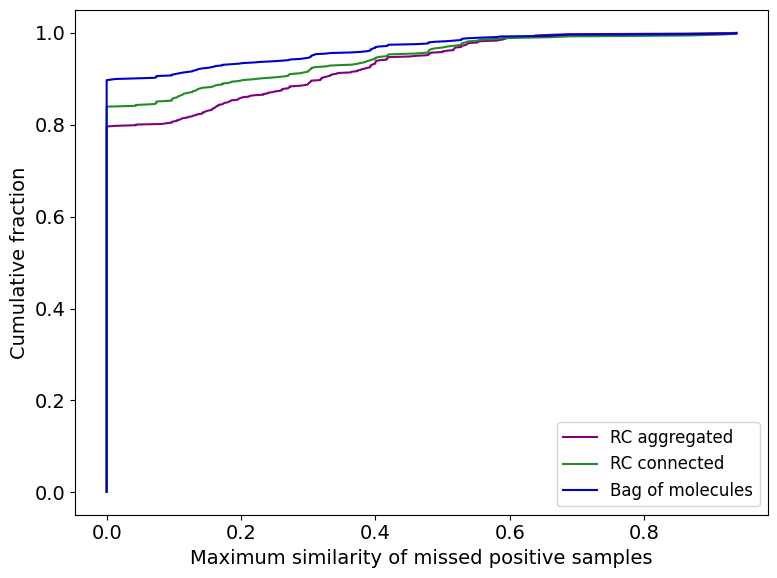

In [381]:
def max_miss_sim_cdf(max_sim_missed, colors=colors, labels=labels):
    '''
    Plots CDF of maximum similarity of missed positive samples.
    '''
    fig, ax = plt.subplots(figsize=(8, 6))

    for k, sims in max_sim_missed.items():
        sims_sorted = np.sort(sims)
        cdf = np.arange(1, len(sims_sorted)+1) / len(sims_sorted)
        ax.plot(sims_sorted, cdf, label=labels.get(k, k), color=colors.get(k))

    ax.set_xlabel('Maximum similarity of missed positive samples')
    ax.set_ylabel('Cumulative fraction')
    ax.legend()
    fig.tight_layout()
    return fig, ax

max_miss_sim_cdf(max_sim_missed)

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Rank', ylabel='RCMCS similarity of nearest true reaction'>)

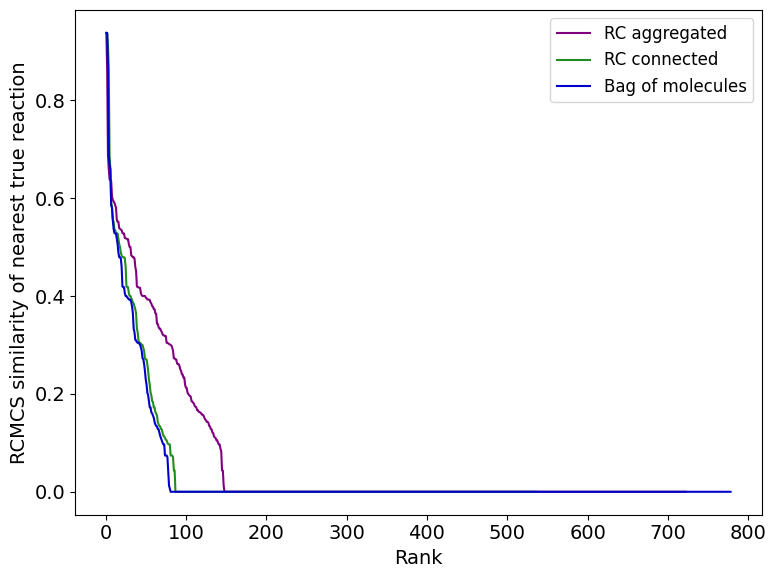

In [386]:
def max_miss_sim_ranked(max_sim_missed, colors=colors, labels=labels):
    '''
    Plots maximum similarity of false positives ranked from highest to lowest.
    '''
    fig, ax = plt.subplots(figsize=(8, 6))
    for k, sims in max_sim_missed.items():
        sims_sorted = np.sort(sims)[::-1]
        ranks = np.arange(1, len(sims_sorted)+1)
        ax.plot(ranks, sims_sorted, label=labels.get(k, k), color=colors.get(k))
    ax.set_xlabel('Rank')
    ax.set_ylabel('RCMCS similarity of nearest true reaction')
    ax.legend()
    fig.tight_layout()
    return fig, ax

max_miss_sim_ranked(max_sim_missed)